## Hyperparameter
- Split Dataset : 60:20:20
- Data Augmentation: No Noise
### Swin Transformer
- Dropout p = 0.3
- Learning Rate = 0.00001
- Weight Decay = 0.02
- Accuracy = 0.99

### EfficientNetV2
- Dropout p = 0.1
- Learning Rate = 0.000001
- Weight Decay = 0.01
- Accuracy = 0.96

# Setup

## Import Library

# Cek GPU

In [8]:
import os
import asyncio
import importlib
import time
import shutil
import random
import copy
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from IPython.core.interactiveshell import InteractiveShell
from PIL import Image
from collections import Counter
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from datetime import datetime
from sklearn.model_selection import KFold
from tqdm import tqdm
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
import seaborn as sns
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import StackingClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split
import xgboost as xgb

import torch
import torchvision.models as models
import torch.nn as nn
from torch.utils.tensorboard import SummaryWriter
from torchinfo import summary
import torch.optim as optim
from torchvision.models import mobilenet_v2, MobileNet_V3_Small_Weights
from torchvision.models import efficientnet_v2_s, EfficientNet_V2_S_Weights
from torchvision.models import swin_t, Swin_T_Weights
from torchvision import datasets
from torchvision.transforms import v2
from torch.utils.data import DataLoader, Dataset
from sklearn.metrics import accuracy_score
from torch.optim.lr_scheduler import ReduceLROnPlateau

In [9]:
torch.cuda.empty_cache()

In [10]:
print(torch.cuda.is_available())

True


# EDA

## Distribusi datasets

Distribusi dataset: {'print': 5025, 'real': 5100, 'replay': 4916}


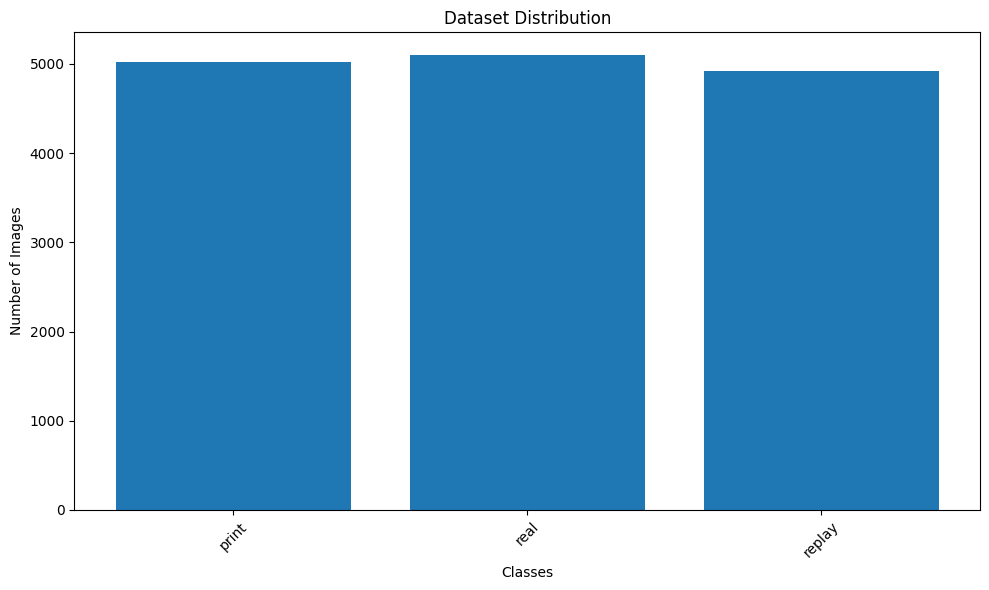

In [11]:
def count_images_in_classes(folder_path):
    """Menghitung jumlah gambar dalam setiap kelas di folder."""
    class_counts = {}
    for class_folder in os.listdir(folder_path):
        class_path = os.path.join(folder_path, class_folder)
        if os.path.isdir(class_path): 
            class_counts[class_folder] = len([
                f for f in os.listdir(class_path) if f.endswith(('.jpg', '.jpeg', '.png'))
            ])
    return class_counts

def plot_distribution(class_counts, title):
    """Menampilkan distribusi dataset menggunakan grafik batang."""
    classes = list(class_counts.keys())
    counts = list(class_counts.values())

    plt.figure(figsize=(10, 6))
    plt.bar(classes, counts)
    plt.xlabel('Classes')
    plt.ylabel('Number of Images')
    plt.title(title)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Path ke folder dataset
home_path = "/home/machi/code/python/TelU-TugasAkhir-LivenessDetection"
dataset_path = f"{home_path}/latest_datasets"

# Hitung distribusi kelas 
datasets_class_counts = count_images_in_classes(dataset_path)
print(f"Distribusi dataset: {datasets_class_counts}")
plot_distribution(datasets_class_counts, "Dataset Distribution")

## Preview datasets

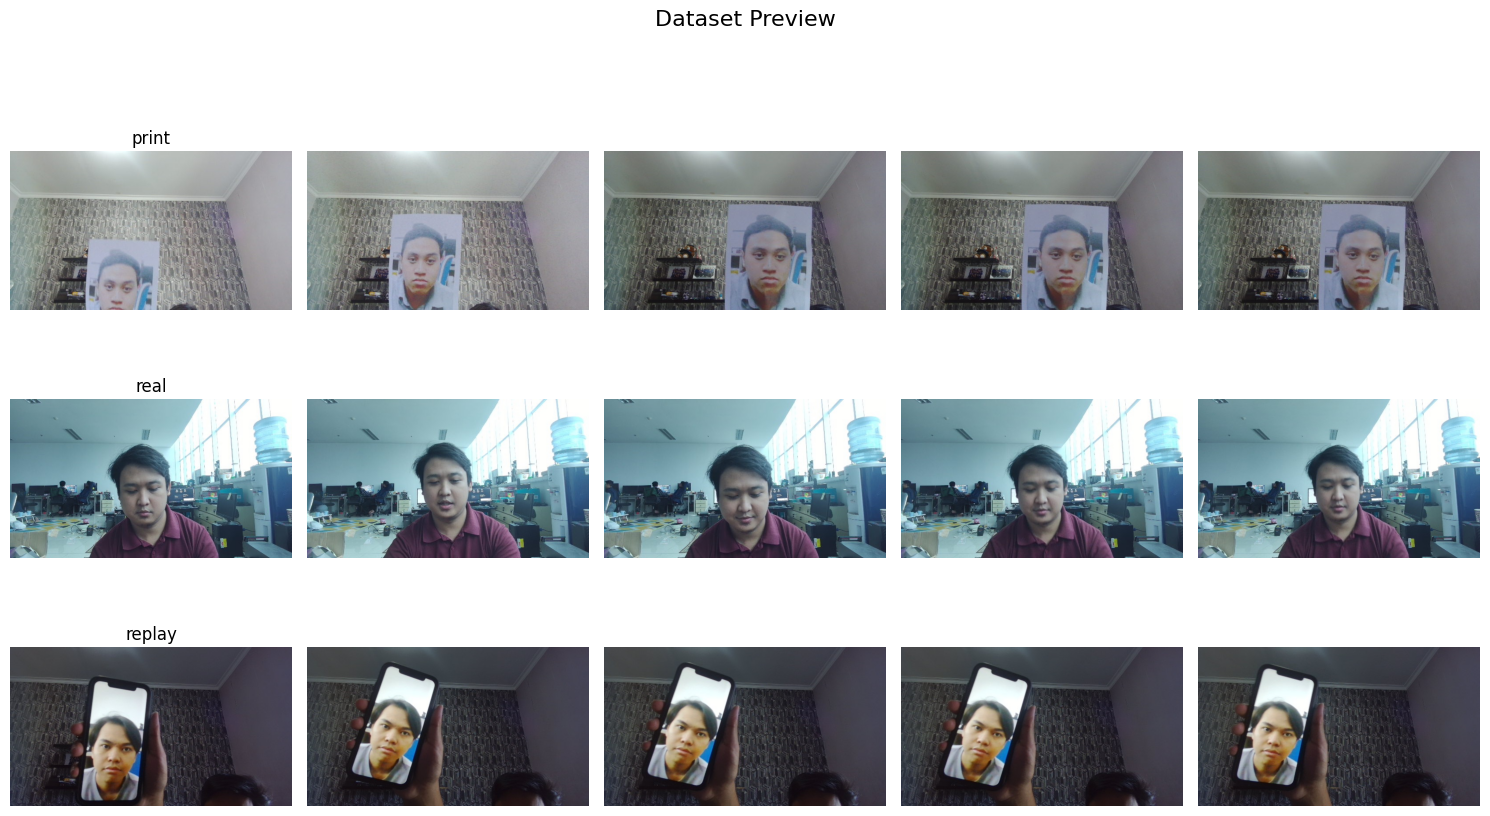

In [12]:
def preview_images(folder_path, title, samples_per_class=5):
    classes = [d for d in os.listdir(folder_path) if os.path.isdir(os.path.join(folder_path, d))]
    num_classes = len(classes)

    # Setup grid untuk menampilkan gambar
    fig, axes = plt.subplots(num_classes, samples_per_class, figsize=(samples_per_class * 3, num_classes * 3))
    fig.suptitle(title, fontsize=16)

    for i, cls in enumerate(classes):
        class_path = os.path.join(folder_path, cls)
        images = [f for f in os.listdir(class_path) if f.endswith(('.jpg', '.jpeg', '.png'))]
        name_video = "video1_"
        sample_images = [img for img in images if name_video in img][:samples_per_class]  # Filter gambar
        
        for j in range(samples_per_class):
            ax = axes[i, j] if num_classes > 1 else axes[j]  # Jika hanya 1 kelas, axes menjadi 1D
            ax.axis('off')

            if j < len(sample_images):  # Jika ada gambar yang cukup
                img_path = os.path.join(class_path, sample_images[j])
                img = Image.open(img_path)
                ax.imshow(img)
                ax.set_title(cls if j == 0 else "")

    plt.tight_layout()
    plt.subplots_adjust(top=0.9)
    plt.show()


# Preview gambar di folder
preview_images(dataset_path, "Dataset Preview", samples_per_class=5)

# EfficientNetV2

In [13]:
# Fungsi untuk menghitung jumlah parameter
def count_params(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

# Membuat dictionary untuk setiap model EfficientNetV2 dan menghitung jumlah parameternya
list_models = {
    "EfficientNetV2_Small": models.efficientnet_v2_s(weights=None),
    "EfficientNetV2_Medium": models.efficientnet_v2_m(weights=None),
    "EfficientNetV2_Large": models.efficientnet_v2_l(weights=None),
}

# Menyimpan hasil dalam dictionary
param_counts = {model_name: count_params(model) for model_name, model in list_models.items()}

# Memformat jumlah parameter dengan titik sebagai pemisah ribuan
formatted_param_counts = {model_name: f"{count:,}".replace(",", ".") for model_name, count in param_counts.items()}

# Menampilkan hasil dalam tabel (pandas DataFrame)
param_df = pd.DataFrame(list(formatted_param_counts.items()), columns=["Model", "Parameter Count"])

# Menampilkan tabel
param_df

,Model,Parameter Count
0,EfficientNetV2_Small,21.458.488
1,EfficientNetV2_Medium,54.139.356
2,EfficientNetV2_Large,118.515.272


# Swin Transformer

In [14]:
# Fungsi untuk menghitung jumlah parameter
def count_params(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

# Membuat dictionary untuk setiap model Swin Transformer dan menghitung jumlah parameternya
list_models = {
    "Swin-Tiny": models.swin_t(weights="IMAGENET1K_V1"),
    "Swin-Small": models.swin_s(weights="IMAGENET1K_V1"),
    "Swin-Base": models.swin_b(weights="IMAGENET1K_V1")
}

# Menyimpan hasil dalam dictionary
param_counts = {model_name: count_params(model) for model_name, model in list_models.items()}

# Memformat jumlah parameter dengan titik sebagai pemisah ribuan
formatted_param_counts = {model_name: f"{count:,}".replace(",", ".") for model_name, count in param_counts.items()}

# Menampilkan hasil dalam tabel (pandas DataFrame)
param_df = pd.DataFrame(list(formatted_param_counts.items()), columns=["Model", "Parameter Count"])

# Menampilkan tabel
param_df

,Model,Parameter Count
0,Swin-Tiny,28.288.354
1,Swin-Small,49.606.258
2,Swin-Base,87.768.224


# Training

## Variable Global

In [15]:
save_model_path = f"{home_path}/results/best_model/"
result_csv_path = f"{home_path}/results/csv/"
image_path = f"{home_path}/results/images/"
class_names = ['real', 'replay', 'print'] 

In [16]:
# Random seed
random.seed(42)

## Hyperparameter Settings

In [17]:
batch_size = 16
epochs_size = 30
optimizer = "Adam"
dropout_rate = 0.2
learning_rate = 0.001
trainable_percentage = 0.3

## Split Dataset

In [18]:
base_path = dataset_path
class_folders = ['real', 'replay', 'print']
file_paths = []
labels = []
video_ids = []

# --- Step 1: Scan folders and prepare the data (Tidak ada perubahan di sini) ---
print("Scanning data folders...")
for folder in class_folders:
    class_path = os.path.join(base_path, folder)
    if not os.path.isdir(class_path):
        print(f"Warning: Directory not found at {class_path}. Skipping.")
        continue
    for filename in os.listdir(class_path):
        if filename.lower().endswith(('.jpg', '.jpeg', '.png')):
            full_file_path = os.path.join(class_path, filename)
            file_paths.append(full_file_path)
            labels.append(folder)
            # Membuat ID unik untuk setiap video
            base_video_id = os.path.splitext(os.path.basename(full_file_path))[0].split('_')[0]
            unique_video_id = f"{folder}_{base_video_id}"
            video_ids.append(unique_video_id)

df = pd.DataFrame({
    'file_path': file_paths,
    'label': labels,
    'video_id': video_ids
})
df['label_encoded'], unique_labels = pd.factorize(df['label'])

print(f"Found {len(df)} total frames from {df['video_id'].nunique()} unique videos.")
class_names = unique_labels.tolist()
print(f"Discovered class names in order: {class_names}")
print("\n" + "="*60 + "\n")


# =============================================================================
# --- STEP 2 & 3: Melakukan Pembagian Data Biasa (Non-Group) ---
# =============================================================================

print("### Performing Regular Stratified Split (Ignoring Video Groups)... ###")

# Pembagian pertama: Pisahkan Test set (20%) dari sisa data (Train+Val, 80%)
# Kita membagi berdasarkan frame individual, bukan grup video.
# `stratify=df['label_encoded']` digunakan untuk menjaga keseimbangan kelas.
train_val_df, test_df = train_test_split(
    df,
    test_size=0.20,
    random_state=42,
    stratify=df['label_encoded']
)

# Pembagian kedua: Pisahkan Validation set dari Train+Val set.
# Kita mengambil 25% dari train_val_df untuk mendapatkan 20% dari total data asli.
train_df, val_df = train_test_split(
    train_val_df,
    test_size=0.25,
    random_state=42,
    stratify=train_val_df['label_encoded']
)

print("Regular splitting complete.")
print("\n--- Final Set Sizes (based on frames) ---")
print(f"Training set:   {len(train_df)} frames")
print(f"Validation set: {len(val_df)} frames")
print(f"Test set:       {len(test_df)} frames")
print("\n" + "="*60 + "\n")


Scanning data folders...
Found 15041 total frames from 34 unique videos.
Discovered class names in order: ['real', 'replay', 'print']


### Performing Regular Stratified Split (Ignoring Video Groups)... ###
Regular splitting complete.

--- Final Set Sizes (based on frames) ---
Training set:   9024 frames
Validation set: 3008 frames
Test set:       3009 frames




## Data Augmentation

In [19]:
def add_random_noise_pytorch(img_tensor):
    """Add Gaussian noise to a PyTorch image tensor."""
    if torch.rand(1).item() > 0.8: # Apply noise 30% of the time
        VARIABILITY = 30
        # Create noise with the same device and shape as the input tensor
        deviation = VARIABILITY * random.random()
        noise = torch.randn(img_tensor.size(), device=img_tensor.device) * deviation
        
        # Add noise and clamp to the valid range
        # Note: We work with float tensors in the [0, 255] range here before scaling
        img_tensor = img_tensor + noise
        img_tensor = torch.clamp(img_tensor, 0, 255)
    
    return img_tensor


In [20]:
# Define Transforms
transform_train = v2.Compose([
    v2.Resize((224, 224)),
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    v2.RandomHorizontalFlip(),
    v2.RandomRotation(20),
    v2.GaussianBlur(kernel_size=3, sigma=(0.1, 0.5)),
    v2.GaussianNoise(mean=0, sigma=0.05),
    #v2.Lambda(add_random_noise_pytorch),
    v2.ColorJitter(brightness=(0.7, 1.4), contrast=(0.8, 1.2)),
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

transform_val_test = v2.Compose([
    v2.Resize((224, 224)),
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


In [21]:
# Create a Custom Dataset Class
class VideoFrameDataset(Dataset):
    def __init__(self, dataframe, transform=None, class_names=None):
        """
        Args:
            dataframe (pd.DataFrame): DataFrame containing file paths and labels.
            transform (callable, optional): Optional transform to be applied on a sample.
        """
        self.dataframe = dataframe
        self.transform = transform
        self.classes = class_names

    def __len__(self):
        """Returns the total number of samples."""
        return len(self.dataframe)

    def __getitem__(self, idx):
        """
        Fetches the sample at the given index.
        1. Gets the file path and label from the DataFrame.
        2. Loads the image from the file path.
        3. Applies the transform (if any).
        4. Returns the transformed image and its label.
        """
        # Get the row from the dataframe
        row = self.dataframe.iloc[idx]
        
        # Get the file path and the encoded label
        image_path = row['file_path']
        label = row['label_encoded']
        
        # Load the image using PIL (Pillow)
        # .convert("RGB") is important to handle grayscale images
        image = Image.open(image_path).convert("RGB")
        
        # Apply the transformations
        if self.transform:
            image = self.transform(image)
        
        return image, label

# Create instances from custom Dataset
train_dataset = VideoFrameDataset(dataframe=train_df, transform=transform_train, class_names=class_names)
val_dataset = VideoFrameDataset(dataframe=val_df, transform=transform_val_test, class_names=class_names)
test_dataset = VideoFrameDataset(dataframe=test_df, transform=transform_val_test, class_names=class_names)


In [22]:
# Run this code right after you create your train_df, val_df, and test_df
print(f"Validation set has {len(val_df)} frames.")
print(f"Number of unique videos in validation set: {val_df['video_id'].nunique()}")

print("\nClass distribution in validation set:")
print(val_df['label'].value_counts())


Validation set has 3008 frames.
Number of unique videos in validation set: 34

Class distribution in validation set:
label
real      1020
print     1005
replay     983
Name: count, dtype: int64


In [23]:
# Run this code right after you create your train_df, val_df, and test_df
print(f"Test set has {len(test_df)} frames.")
print(f"Number of unique videos in test set: {test_df['video_id'].nunique()}")

print("\nClass distribution in test set:")
print(test_df['label'].value_counts())


Test set has 3009 frames.
Number of unique videos in test set: 34

Class distribution in test set:
label
real      1020
print     1005
replay     984
Name: count, dtype: int64


In [24]:
class_counts = train_df['label'].value_counts().sort_index()
print("Jumlah sampel per kelas di Training Set:", end=" ")
print(class_counts)

total_samples = len(train_df)
num_classes = len(class_names)
class_weights = total_samples / (num_classes * class_counts)

print("\nBobot yang dihitung untuk setiap kelas:", end=" ")
print(class_weights)

Jumlah sampel per kelas di Training Set: label
print     3015
real      3060
replay    2949
Name: count, dtype: int64

Bobot yang dihitung untuk setiap kelas: label
print     0.997678
real      0.983007
replay    1.020007
Name: count, dtype: float64


In [25]:
# Create the DataLoaders

BATCH_SIZE = 16

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

## Build Model

In [26]:
print(torch.cuda.is_available())

True


In [27]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [28]:
def train_model(model, train_dataloader, val_dataloader, optimizer, criterion, device, num_epochs=25):
    """
    Trains and validates a model, now with a learning rate scheduler and logic to save the best model.
    """
    start_time = time.time()
    
    # Lists to store metrics for plotting
    history = {
        'train_loss': [], 'train_acc': [],
        'val_loss': [], 'val_acc': []
    }

    # Variables to track the best model found so far
    best_val_accuracy = 0.0
    # Create a deep copy of the model's initial state dictionary
    best_model_wts = copy.deepcopy(model.state_dict()) 

    # Make sure the model is on the correct device before starting
    model.to(device)

    for epoch in range(num_epochs):
        print(f"Epoch {epoch+1}/{num_epochs} => ", end='')

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
                dataloader = train_dataloader
            else:
                model.eval()   # Set model to evaluate mode
                dataloader = val_dataloader

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloader:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            # Calculate and store epoch metrics
            epoch_loss = running_loss / len(dataloader.dataset)
            epoch_acc = running_corrects.double() / len(dataloader.dataset)
            
            history[f'{phase}_loss'].append(epoch_loss)
            history[f'{phase}_acc'].append(epoch_acc.item())

            print(f'{phase.capitalize()} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f} | ', end='')

            # Deep copy the model if it's the best one so far (based on validation accuracy)
            if phase == 'val' and epoch_acc > best_val_accuracy:
                best_val_accuracy = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                print(f'New best model saved!', end='')
        
        
        print()

    # --- End of Training ---
    time_elapsed = time.time() - start_time
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_val_accuracy:.4f}')

    # Load the best model weights back into the model
    model.load_state_dict(best_model_wts)
    return model, history


In [29]:
date_now = datetime.now().strftime("%m-%d-%H")
current_date = "07-02-05"
folder_save = f"{home_path}/results/GroupShuffle/"
print(current_date)

07-02-05


### Model Pretrained Swin Transformer + Weights

In [92]:
weights = Swin_T_Weights.DEFAULT
model = swin_t(weights=weights, progress=True)

num_classes = 3

# print("Freezing backbone layers...")
for param in model.features.parameters():
    param.requires_grad = False


# Dropout regularization
in_features = model.head.in_features
dropout_prob = 0.3 
model.head = nn.Sequential(
    nn.Dropout(p=dropout_prob),
    nn.Linear(in_features, num_classes)
)

model = model.to(device)
summary(model, 
        input_size=(16, 3, 224, 224), 
        col_names=["input_size", "output_size", "num_params", "trainable"])


Layer (type:depth-idx)                             Input Shape               Output Shape              Param #                   Trainable
SwinTransformer                                    [16, 3, 224, 224]         [16, 3]                   --                        Partial
├─Sequential: 1-1                                  [16, 3, 224, 224]         [16, 7, 7, 768]           --                        False
│    └─Sequential: 2-1                             [16, 3, 224, 224]         [16, 56, 56, 96]          --                        False
│    │    └─Conv2d: 3-1                            [16, 3, 224, 224]         [16, 96, 56, 56]          (4,704)                   False
│    │    └─Permute: 3-2                           [16, 96, 56, 56]          [16, 56, 56, 96]          --                        --
│    │    └─LayerNorm: 3-3                         [16, 56, 56, 96]          [16, 56, 56, 96]          (192)                     False
│    └─Sequential: 2-2                             [

In [93]:
# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(
    filter(lambda p: p.requires_grad, model.parameters()), 
    lr=0.00001, 
    weight_decay=0.02
)


In [94]:
best_model, history = train_model(
    model=model,
    train_dataloader=train_dataloader,
    val_dataloader=val_dataloader, 
    optimizer=optimizer,
    criterion=criterion,
    device=device,
    num_epochs=20 
) 


Epoch 1/20 => Train Loss: 0.9547 Acc: 0.5667 | Val Loss: 0.8493 Acc: 0.6513 | New best model saved!
Epoch 2/20 => Train Loss: 0.7221 Acc: 0.7660 | Val Loss: 0.6933 Acc: 0.7872 | New best model saved!
Epoch 3/20 => Train Loss: 0.5796 Acc: 0.8536 | Val Loss: 0.5875 Acc: 0.8521 | New best model saved!
Epoch 4/20 => Train Loss: 0.4794 Acc: 0.8976 | Val Loss: 0.5082 Acc: 0.8767 | New best model saved!
Epoch 5/20 => Train Loss: 0.4062 Acc: 0.9214 | Val Loss: 0.4473 Acc: 0.8890 | New best model saved!
Epoch 6/20 => Train Loss: 0.3488 Acc: 0.9399 | Val Loss: 0.3973 Acc: 0.9046 | New best model saved!
Epoch 7/20 => Train Loss: 0.3066 Acc: 0.9502 | Val Loss: 0.3552 Acc: 0.9176 | New best model saved!
Epoch 8/20 => Train Loss: 0.2716 Acc: 0.9570 | Val Loss: 0.3180 Acc: 0.9309 | New best model saved!
Epoch 9/20 => Train Loss: 0.2402 Acc: 0.9631 | Val Loss: 0.2876 Acc: 0.9368 | New best model saved!
Epoch 10/20 => Train Loss: 0.2130 Acc: 0.9710 | Val Loss: 0.2642 Acc: 0.9418 | New best model saved!

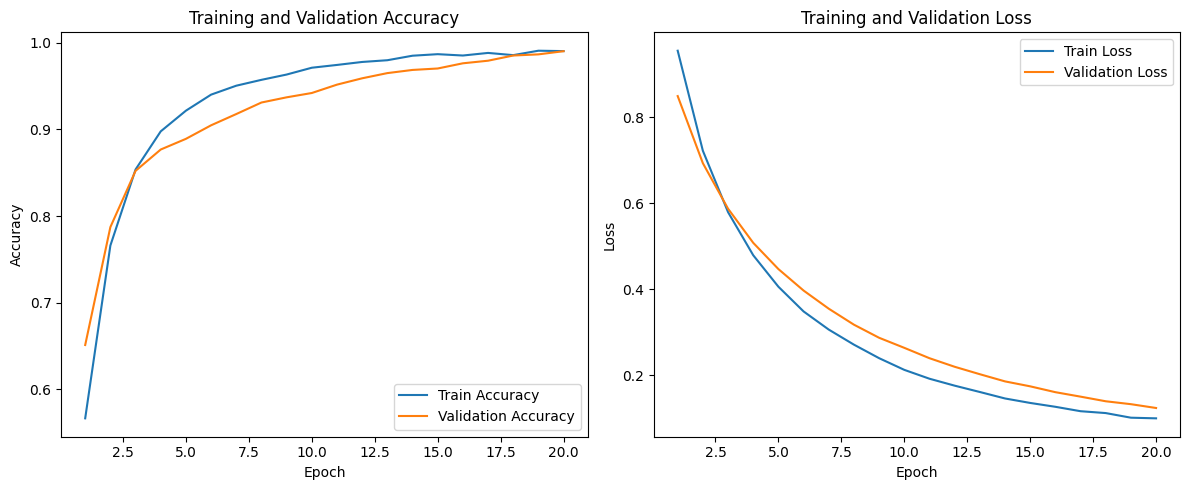

In [95]:
num_epochs = 20

# Step 2: Plot the metrics
plt.figure(figsize=(12, 5))

# Plot Training and Validation Accuracy
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), history["train_acc"], label="Train Accuracy")
plt.plot(range(1, num_epochs + 1), history["val_acc"], label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training and Validation Accuracy")
plt.legend()
 
# Plot Training and Validation Loss
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), history["train_loss"], label="Train Loss")
plt.plot(range(1, num_epochs + 1), history["val_loss"], label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()

plt.tight_layout()
plt.show()

In [96]:
# Model evaluation
best_model.eval()
predictions = []
true_labels = []
with torch.no_grad():
    for images, labels in test_dataloader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = best_model(images)
        _, preds = torch.max(outputs, 1)
        predictions.extend(preds.cpu().numpy())
        true_labels.extend(labels.cpu().numpy())

In [97]:
print(classification_report(true_labels, predictions, target_names=test_dataset.classes))

              precision    recall  f1-score   support

        real       0.96      1.00      0.98      1020
      replay       1.00      0.98      0.99       984
       print       1.00      0.98      0.99      1005

    accuracy                           0.99      3009
   macro avg       0.99      0.99      0.99      3009
weighted avg       0.99      0.99      0.99      3009



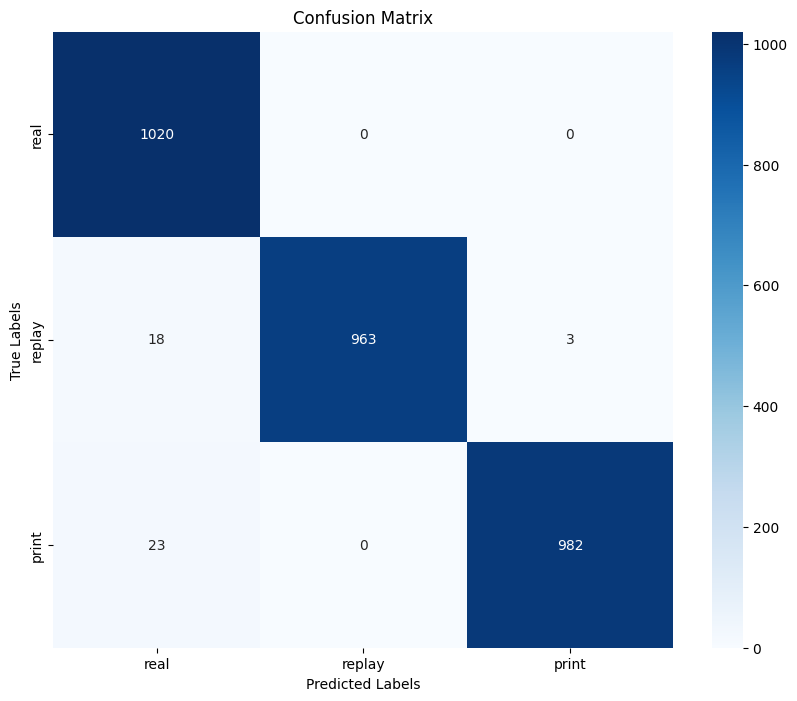

In [98]:
# Step 2: Compute the confusion matrix
cm = confusion_matrix(true_labels, predictions)

# Step 3: Visualize the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=test_dataset.classes, yticklabels=test_dataset.classes)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

In [99]:
# Save model
torch.save(best_model.state_dict(), f'{folder_save}/Swin-Transformer-Weight-CA-dict-doandl2-{current_date}.pth')
torch.save(best_model, f'{folder_save}/Swin-Transformer-Weight-CA-doandl2-{current_date}.pth')
torch.save(history, f'{folder_save}/Swin-Transformer-Weight-CA-history-doandl2-{current_date}.pth')

### Model Pretrained EfficientNet + Weights

In [100]:
torch.cuda.empty_cache()

In [101]:
weights = EfficientNet_V2_S_Weights.DEFAULT
model = efficientnet_v2_s(weights=weights, progress=True)
num_classes = 3

# Freeze the backbone
# for param in model.features.parameters():
#     param.requires_grad = False

# Get the number of input features from the original linear layer
in_features = model.classifier[1].in_features

# Replace the entire classifier with a new Sequential block
dropout_prob = 0.1
model.classifier = nn.Sequential(
    nn.Dropout(p=dropout_prob),
    nn.Linear(in_features, num_classes)
)

model = model.to(device)
summary(model, input_size=(1, 3, 224, 224))


Layer (type:depth-idx)                                  Output Shape              Param #
EfficientNet                                            [1, 3]                    --
├─Sequential: 1-1                                       [1, 1280, 7, 7]           --
│    └─Conv2dNormActivation: 2-1                        [1, 24, 112, 112]         --
│    │    └─Conv2d: 3-1                                 [1, 24, 112, 112]         648
│    │    └─BatchNorm2d: 3-2                            [1, 24, 112, 112]         48
│    │    └─SiLU: 3-3                                   [1, 24, 112, 112]         --
│    └─Sequential: 2-2                                  [1, 24, 112, 112]         --
│    │    └─FusedMBConv: 3-4                            [1, 24, 112, 112]         5,232
│    │    └─FusedMBConv: 3-5                            [1, 24, 112, 112]         5,232
│    └─Sequential: 2-3                                  [1, 48, 56, 56]           --
│    │    └─FusedMBConv: 3-6                         

In [102]:
# Loss function and optimizer
#class_weights = torch.tensor([1.0/1020, 1.0/984, 1.0/1005,], dtype=torch.float32).to(device)
weights_tensor = torch.tensor(class_weights.values, dtype=torch.float32).to(device)
criterion = nn.CrossEntropyLoss(weight=weights_tensor)
optimizer = optim.Adam(
    filter(lambda p: p.requires_grad, model.parameters()), 
    lr=0.000001, 
    weight_decay=0.01
)

In [103]:
best_model, history = train_model(
    model=model,
    train_dataloader=train_dataloader,
    val_dataloader=val_dataloader,
    optimizer=optimizer,
    criterion=criterion,
    device=device,  
    num_epochs=20 
)

Epoch 1/20 => Train Loss: 0.9646 Acc: 0.6607 | Val Loss: 0.9787 Acc: 0.6120 | New best model saved!
Epoch 2/20 => Train Loss: 0.6844 Acc: 0.9010 | Val Loss: 0.8871 Acc: 0.7227 | New best model saved!
Epoch 3/20 => Train Loss: 0.4309 Acc: 0.9508 | Val Loss: 0.7711 Acc: 0.8344 | New best model saved!
Epoch 4/20 => Train Loss: 0.2661 Acc: 0.9722 | Val Loss: 0.6951 Acc: 0.8271 | 
Epoch 5/20 => Train Loss: 0.1739 Acc: 0.9832 | Val Loss: 0.6313 Acc: 0.8614 | New best model saved!
Epoch 6/20 => Train Loss: 0.1179 Acc: 0.9879 | Val Loss: 0.5673 Acc: 0.8411 | 
Epoch 7/20 => Train Loss: 0.0897 Acc: 0.9922 | Val Loss: 0.5067 Acc: 0.8700 | New best model saved!
Epoch 8/20 => Train Loss: 0.0679 Acc: 0.9935 | Val Loss: 0.4869 Acc: 0.8670 | 
Epoch 9/20 => Train Loss: 0.0589 Acc: 0.9939 | Val Loss: 0.4030 Acc: 0.8939 | New best model saved!
Epoch 10/20 => Train Loss: 0.0500 Acc: 0.9945 | Val Loss: 0.4393 Acc: 0.8640 | 
Epoch 11/20 => Train Loss: 0.0411 Acc: 0.9970 | Val Loss: 0.4826 Acc: 0.8464 | 
Epo

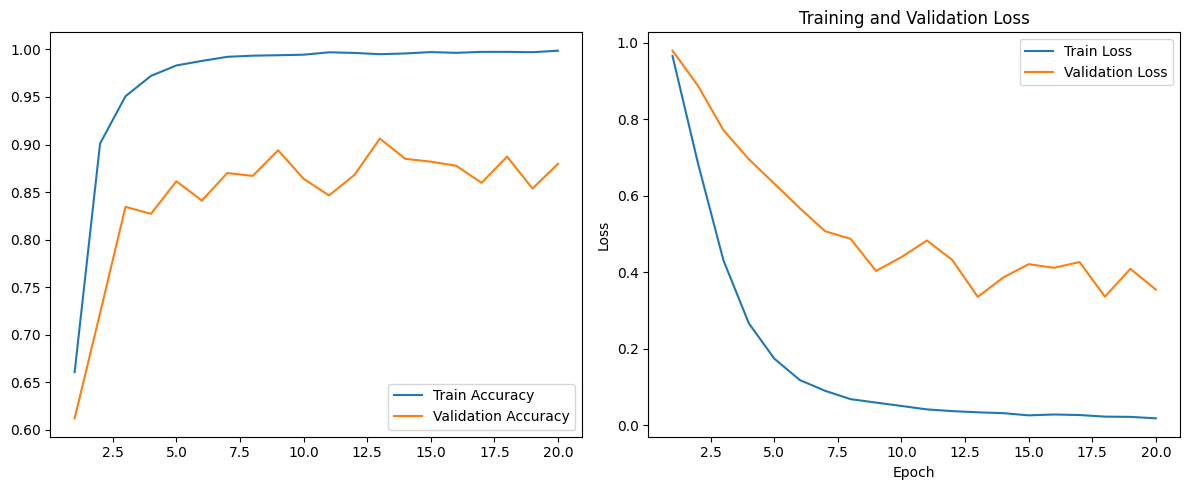

In [104]:
num_epochs = 20

# Step 2: Plot the metrics
plt.figure(figsize=(12, 5))

# Plot Training and Validation Accuracy
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), history["train_acc"], label="Train Accuracy")
plt.plot(range(1, num_epochs + 1), history["val_acc"], label="Validation Accuracy")
plt.legend()

# Plot Training and Validation Loss
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), history["train_loss"], label="Train Loss")
plt.plot(range(1, num_epochs + 1), history["val_loss"], label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()

plt.tight_layout()
plt.show()

In [105]:
# Model evaluation
best_model.eval()
predictions = []
true_labels = []
with torch.no_grad():
    for images, labels in test_dataloader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = best_model(images)
        _, preds = torch.max(outputs, 1)
        predictions.extend(preds.cpu().numpy())
        true_labels.extend(labels.cpu().numpy())

In [106]:
print(classification_report(true_labels, predictions, target_names=test_dataset.classes))

              precision    recall  f1-score   support

        real       1.00      0.83      0.90      1020
      replay       0.86      0.99      0.92       984
       print       0.94      0.96      0.95      1005

    accuracy                           0.92      3009
   macro avg       0.93      0.92      0.92      3009
weighted avg       0.93      0.92      0.92      3009



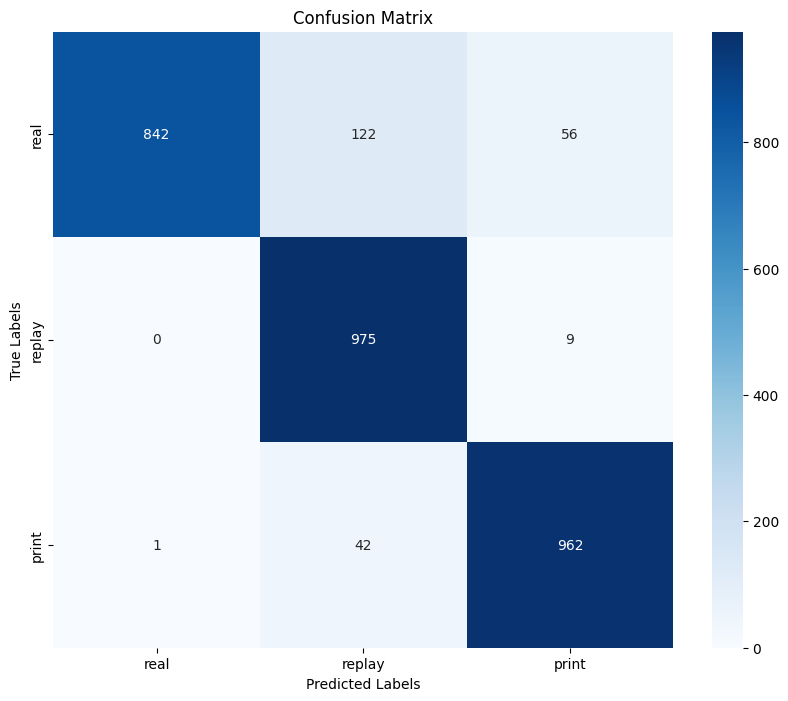

In [107]:
# Step 2: Compute the confusion matrix
cm = confusion_matrix(true_labels, predictions)

# Step 3: Visualize the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=test_dataset.classes, yticklabels=test_dataset.classes)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

In [108]:
# Save model
torch.save(best_model.state_dict(), f'{folder_save}/EfficientNetV2-Weights-CA-dict-doandl2-{current_date}.pth')
torch.save(best_model, f'{folder_save}/EfficientNetV2-Weights-CA-doandl2-{current_date}.pth')
torch.save(best_model, f'{folder_save}/EfficientNetV2-Weights-CA-history-doandl2-{current_date}.pth')

- Swin Name Files: "Swin-Transformer-Weight-CA-dict-doandl2-07-01-16"
- EffiecientNet: "EfficientNetV2-Weights-CA-dict-doandl2-07-01-18"

### Wrapper

In [56]:
torch.cuda.empty_cache()

In [25]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
RANDOM_STATE = 42
NUM_CLASSES = 3
N_SPLITS = 5  
BATCH_SIZE = 16

In [26]:
class PyTorchModelWrapper(BaseEstimator, ClassifierMixin):
    """
    Sebuah wrapper untuk membuat model PyTorch kompatibel dengan API Scikit-learn,
    terutama untuk digunakan dalam pipeline seperti StackingClassifier.
    """
    def __init__(self, model_fn, optimizer_cls, criterion, num_epochs=10, batch_size=16, lr=1e-4, weight_decay=0.01):
        self.model_fn = model_fn
        self.optimizer_cls = optimizer_cls
        self.criterion = criterion
        self.num_epochs = num_epochs
        self.batch_size = batch_size
        self.lr = lr
        self.weight_decay = weight_decay
        self.model_ = None
        self.classes_ = np.arange(NUM_CLASSES) 

    def fit(self, X, y):
        # Scikit-learn akan memberikan X (DataFrame) dan y (label)
        self.model_ = self.model_fn().to(DEVICE)
        optimizer = self.optimizer_cls(self.model_.parameters(), lr=self.lr, weight_decay=self.weight_decay)
        
        fit_df = X.copy()
        fit_df['label_encoded'] = y
        
        train_dataset = VideoFrameDataset(fit_df, transform=transform_train, class_names=class_names)
        train_loader = DataLoader(train_dataset, batch_size=self.batch_size, shuffle=True)
        
        print(f"  Melatih {self.model_.__class__.__name__} pada {len(X)} sampel selama {self.num_epochs} epoch...")
        
        # Loop training 
        for epoch in range(self.num_epochs):
            self.model_.train()
            for inputs, labels in train_loader:
                inputs = inputs.to(DEVICE)
                labels = labels.to(DEVICE)
                optimizer.zero_grad()
                outputs = self.model_(inputs)
                loss = self.criterion(outputs, labels)
                loss.backward()
                optimizer.step()
        return self

    def predict_proba(self, X):
        self.model_.eval()
        all_probs = []

        predict_df = X.copy()
        if 'label_encoded' not in predict_df.columns:
            predict_df['label_encoded'] = 0 # Kolom dummy jika diperlukan

        val_dataset = VideoFrameDataset(predict_df, transform=transform_val_test, class_names=class_names)
        val_loader = DataLoader(val_dataset, batch_size=self.batch_size, shuffle=False)
        
        with torch.no_grad():
            for inputs, _ in val_loader:
                inputs = inputs.to(DEVICE)
                outputs = self.model_(inputs)
                probs = torch.nn.functional.softmax(outputs, dim=1)
                all_probs.append(probs.cpu().numpy())
            
        return np.concatenate(all_probs)

    def predict(self, X):
        probas = self.predict_proba(X)
        return np.argmax(probas, axis=1)

In [27]:
def get_swin_model():
    # 1. Muat model dengan bobot pre-trained
    weights = Swin_T_Weights.DEFAULT
    model = swin_t(weights=weights)

    for param in model.features.parameters():
        param.requires_grad = False

    # 3. Ganti head classifier untuk tugas kita
    in_features = model.head.in_features
    model.head = nn.Sequential(
        nn.Dropout(p=0.3),
        nn.Linear(in_features, NUM_CLASSES)
    )
    return model


def get_efficientnet_model():
    # 1. Muat model dengan bobot pre-trained
    weights = EfficientNet_V2_S_Weights.DEFAULT
    model = efficientnet_v2_s(weights=weights)

    # # 2. Bekukan backbone
    for param in model.features.parameters():
        param.requires_grad = False #

    # 3. Ganti head classifier
    in_features = model.classifier[1].in_features
    model.classifier = nn.Sequential(
        nn.Dropout(p=0.1),
        nn.Linear(in_features, NUM_CLASSES)
    )
    return model


### Build Ensemble Stacking

In [ ]:
base_estimator_swin = PyTorchModelWrapper(
    model_fn=get_swin_model,
    optimizer_cls=optim.Adam,
    criterion=nn.CrossEntropyLoss(),
    num_epochs=5, # Jumlah epoch untuk melatih setiap fold
    lr=0.00001,
    weight_decay=0.02
)

weights_tensor = torch.tensor(class_weights.values, dtype=torch.float32).to(DEVICE)
base_estimator_effnet = PyTorchModelWrapper(
    model_fn=get_efficientnet_model,
    optimizer_cls=optim.Adam,
    criterion=nn.CrossEntropyLoss(weight=weights_tensor),
    num_epochs=5,
    lr=0.000001,
    weight_decay=0.01
)

# 2. Definisikan meta-learner (final estimator)
meta_learner = xgb.XGBClassifier(
    objective='multi:softmax',
    num_class=NUM_CLASSES,
    eval_metric='mlogloss',
    eta=0.1,
    max_depth=4,
    random_state=RANDOM_STATE
)

# 3. Buat daftar estimator dasar
estimators = [
    ('swin_transformer', base_estimator_swin),
    ('efficientnet_v2', base_estimator_effnet)
]

# 4. Definisikan strategi cross-validation
cv_strategy = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=RANDOM_STATE)

# 5. Buat Stacking Classifier
stacking_clf = StackingClassifier(
    estimators=estimators,
    final_estimator=meta_learner,
    cv=cv_strategy,
    stack_method='predict_proba', 
    n_jobs=1, 
    verbose=2 
)

### Train

In [29]:
X_train = train_df.drop('label_encoded', axis=1)
y_train = train_df['label_encoded']
X_test = test_df.drop('label_encoded', axis=1)
y_test = test_df['label_encoded']

# Latih keseluruhan ensemble
stacking_clf.fit(X_train, y_train)
print("Stacking Classifier berhasil dilatih.")

  Melatih SwinTransformer pada 9024 sampel selama 5 epoch...
  Melatih EfficientNet pada 9024 sampel selama 5 epoch...
  Melatih SwinTransformer pada 7219 sampel selama 5 epoch...
  Melatih SwinTransformer pada 7219 sampel selama 5 epoch...
  Melatih SwinTransformer pada 7219 sampel selama 5 epoch...
  Melatih SwinTransformer pada 7219 sampel selama 5 epoch...
  Melatih SwinTransformer pada 7220 sampel selama 5 epoch...
  Melatih EfficientNet pada 7219 sampel selama 5 epoch...
  Melatih EfficientNet pada 7219 sampel selama 5 epoch...
  Melatih EfficientNet pada 7219 sampel selama 5 epoch...
  Melatih EfficientNet pada 7219 sampel selama 5 epoch...
  Melatih EfficientNet pada 7220 sampel selama 5 epoch...
Stacking Classifier berhasil dilatih.


/home/machi/.local/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [08:27:57] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


### Testing


Tahap 3: Melakukan evaluasi akhir pada Test Set...

Akurasi Akhir Ensemble Stacking pada Test Set: 0.9794

Laporan Klasifikasi:
              precision    recall  f1-score   support

        real       0.98      0.97      0.98      1020
      replay       1.00      0.97      0.99       984
       print       0.96      1.00      0.98      1005

    accuracy                           0.98      3009
   macro avg       0.98      0.98      0.98      3009
weighted avg       0.98      0.98      0.98      3009



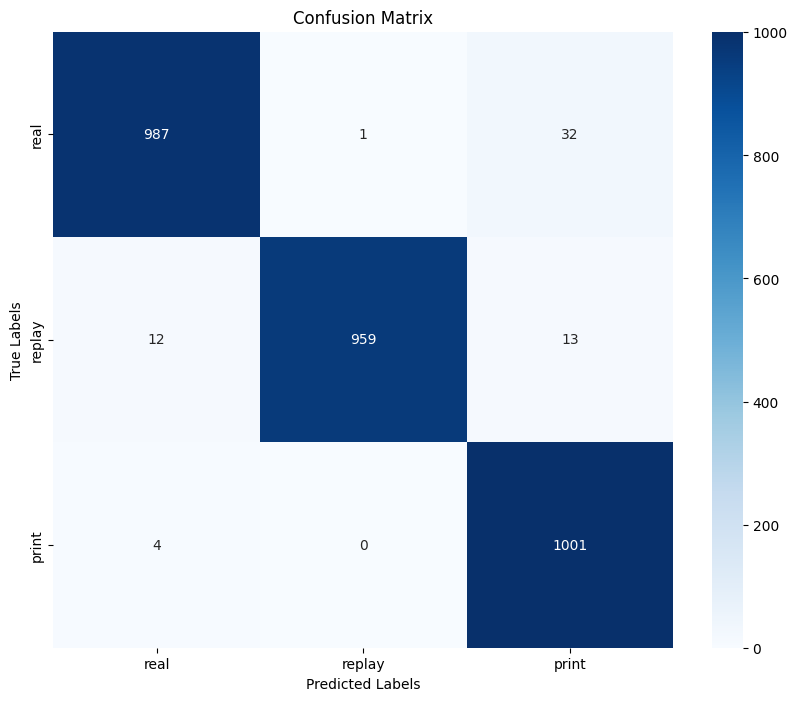

In [30]:
print("\nTahap 3: Melakukan evaluasi akhir pada Test Set...")
final_predictions = stacking_clf.predict(X_test)
final_accuracy = accuracy_score(y_test, final_predictions)

print(f"\nAkurasi Akhir Ensemble Stacking pada Test Set: {final_accuracy:.4f}")
print("\nLaporan Klasifikasi:")
print(classification_report(y_test, final_predictions, target_names=class_names))

# Step 2: Compute the confusion matrix
cm = confusion_matrix(y_test, final_predictions)

# Step 3: Visualize the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=test_dataset.classes, yticklabels=test_dataset.classes)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

### Saving Ensemble Model

In [36]:
try:
    trained_swin_model = stacking_clf.estimators_[0].model_
    torch.save(trained_swin_model.state_dict(), os.path.join(folder_save, f"swin_transformer_base-{current_date}.pth"))

    trained_effnet_model = stacking_clf.estimators_[1].model_
    torch.save(trained_effnet_model.state_dict(), os.path.join(folder_save, f"efficientnet_v2_base-{current_date}.pth"))
except Exception as e:
    print(f"Gagal menyimpan model dasar PyTorch. Pastikan 'stacking_clf' sudah dilatih. Error: {e}")


# 2. Menyimpan Meta-Learner (Final Estimator)
# Meta-learner yang sudah dilatih disimpan dalam atribut .final_estimator_
try:
    meta_learner_xgb = stacking_clf.final_estimator_
    meta_learner_xgb.save_model(os.path.join(folder_save, f"xgb_meta_learner-{current_date}.json"))
except Exception as e:
    print(f"Gagal menyimpan meta-learner XGBoost. Error: {e}")

### Pipeline to Use Ensemble Stacking

In [30]:
class LivenessEnsemblePipeline:
    def __init__(self, model_dir, device):
        self.device = device
        self.model_dir = model_dir
        self.class_names = ['real', 'replay', 'print'] 

        # Inisialisasi arsitektur dan muat bobot
        self.swin_model = self._load_swin_model()
        self.effnet_model = self._load_effnet_model()
        self.xgb_model = self._load_xgb_model()

        # Siapkan pipeline transformasi untuk gambar input
        self.transform = v2.Compose([
            v2.Resize((224, 224)),
            v2.ToImage(),
            v2.ToDtype(torch.float32, scale=True),
            v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ])

    def _load_swin_model(self):
        try:
            model = swin_t(weights=None, num_classes=3)
            model.head = nn.Sequential(nn.Dropout(p=0.5), nn.Linear(model.head.in_features, 3))
            model.load_state_dict(torch.load(os.path.join(self.model_dir, f"swin_transformer_base-{current_date}.pth"), map_location=self.device))
            model.to(self.device)
            model.eval()
            return model
        except FileNotFoundError:
            print(f"❌ ERROR: File bobot 'swin_transformer_base.pth' tidak ditemukan di '{self.model_dir}'")
            return None

    def _load_effnet_model(self):
        try:
            model = efficientnet_v2_s(weights=None, num_classes=3)
            in_features = model.classifier[1].in_features
            model.classifier = nn.Sequential(nn.Dropout(p=0.5), nn.Linear(in_features, 3))
            model.load_state_dict(torch.load(os.path.join(self.model_dir, f"efficientnet_v2_base-{current_date}.pth"), map_location=self.device))
            model.to(self.device)
            model.eval()
            return model
        except FileNotFoundError:
            print(f"❌ ERROR: File bobot 'efficientnet_v2_base.pth' tidak ditemukan di '{self.model_dir}'")
            return None

    def _load_xgb_model(self):
        try:
            model = xgb.XGBClassifier()
            model.load_model(os.path.join(self.model_dir, f"xgb_meta_learner-{current_date}.json"))
            return model
        except (xgb.core.XGBoostError, FileNotFoundError):
            print(f"❌ ERROR: File meta-learner 'xgb_meta_learner.json' tidak ditemukan di '{self.model_dir}'")
            return None

    def predict(self, image_path):
        """
        Membuat prediksi pada satu file gambar dan mengembalikan hasilnya dalam bentuk dictionary.
        """
        # Pastikan semua model berhasil dimuat
        if not all([self.swin_model, self.effnet_model, self.xgb_model]):
            print("Tidak bisa melakukan prediksi karena salah satu atau lebih model gagal dimuat.")
            return None
            
        try:
            image = Image.open(image_path).convert("RGB")
            input_tensor = self.transform(image).unsqueeze(0).to(self.device)

            with torch.no_grad():
                # Langkah 1: Dapatkan probabilitas dari model dasar
                swin_probs = torch.nn.functional.softmax(self.swin_model(input_tensor), dim=1)
                effnet_probs = torch.nn.functional.softmax(self.effnet_model(input_tensor), dim=1)
                
                # Langkah 2: Gabungkan probabilitas menjadi fitur untuk XGBoost
                meta_features = torch.cat((swin_probs, effnet_probs), dim=1).cpu().numpy()
                
                # Langkah 3: Dapatkan PROBABILITAS dari XGBoost, bukan hanya prediksi
                final_probabilities = self.xgb_model.predict_proba(meta_features)[0]
                
                # Langkah 4: Hitung hasil akhir
                predicted_idx = np.argmax(final_probabilities)
                confidence = final_probabilities[predicted_idx]
                predicted_class = self.class_names[predicted_idx]

                # Kembalikan hasil dalam format dictionary yang terstruktur
                return {
                    "predicted_class": predicted_class,
                    "confidence": float(confidence),
                    "all_probabilities": {name: float(prob) for name, prob in zip(self.class_names, final_probabilities)}
                }

        except FileNotFoundError:
            print(f"Error: File gambar tidak ditemukan di '{image_path}'")
            return None
        except Exception as e:
            print(f"Terjadi kesalahan saat prediksi: {e}")
            return None

    def display_prediction_results(self, prediction_result):
        """Menampilkan hasil prediksi yang terstruktur dari metode .predict()"""
        if prediction_result is None:
            return

        print(f"\n--- Hasil Prediksi Ensemble ---")
        print(f"Kelas Terprediksi: {prediction_result['predicted_class']}")
        print(f"Tingkat Kepercayaan: {prediction_result['confidence']:.4f}")
        print("\nProbabilitas untuk semua kelas:")
        for class_name, prob in prediction_result['all_probabilities'].items():
            print(f"  - {class_name}: {prob:.4f}")

## Test Model

### Pipeline to Use Base Model

In [31]:
def load_inference_model(model_type, model_path, num_classes, device):
    """
    Memuat, membangun, dan menyiapkan model untuk inferensi.
    Fungsi ini dapat digunakan kembali untuk model yang berbeda.

    Args:
        model_type (str): Tipe model, 'swin' atau 'efficientnet'.
        model_path (str): Path ke file bobot model (.pth).
        num_classes (int): Jumlah kelas output.
        device: Device PyTorch (CPU atau CUDA).

    Returns:
        model: Model PyTorch yang sudah dilatih dan siap untuk evaluasi.
    """
    print(f"--- Memuat model tipe: {model_type} ---")
    
    # Inisialisasi model berdasarkan tipenya
    if model_type.lower() == 'swin':
        model = swin_t(weights=None, num_classes=num_classes)
        # Rekonstruksi head yang sama persis seperti saat training
        in_features = model.head.in_features
        model.head = nn.Sequential(
            nn.Dropout(p=0.3), # Ganti dropout jika berbeda saat training
            nn.Linear(in_features, num_classes)
        )
    elif model_type.lower() == 'efficientnet':
        model = efficientnet_v2_s(weights=None, num_classes=num_classes)
        # Rekonstruksi classifier yang sama persis seperti saat training
        in_features = model.classifier[1].in_features
        model.classifier = nn.Sequential(
            nn.Dropout(p=0.1), # Ganti dropout jika berbeda saat training
            nn.Linear(in_features, num_classes)
        )
    else:
        raise ValueError("Tipe model tidak dikenal. Gunakan 'swin' atau 'efficientnet'.")

    # Muat bobot yang sudah dilatih
    try:
        model.load_state_dict(torch.load(model_path, map_location=device))
        print(f"Bobot berhasil dimuat dari: {model_path}")
    except FileNotFoundError:
        print(f"ERROR: File bobot tidak ditemukan di {model_path}")
        return None
    except RuntimeError as e:
        print(f"ERROR: Struktur model tidak cocok dengan file bobot. Pastikan arsitektur sama. Detail: {e}")
        return None
        
    # Siapkan model untuk inferensi
    model.to(device)
    model.eval()
    
    return model

def load_and_preprocess_image(image_path, transform):
    """Memuat gambar, melakukan preprocessing, dan mengembalikannya sebagai tensor."""
    try:
        image = Image.open(image_path).convert("RGB")
    except FileNotFoundError:
        print(f"Error: File gambar tidak ditemukan di {image_path}")
        return None
    image_tensor = transform(image).unsqueeze(0)
    return image_tensor

def predict(model, image_tensor, device):
    """Melakukan inferensi pada model dan mengembalikan prediksi."""
    if image_tensor is None or model is None:
        return None
    image_tensor = image_tensor.to(device)
    with torch.no_grad():
        output = model(image_tensor)
    return output

def display_results(output, class_names):
    """Menampilkan hasil prediksi."""
    if output is None:
        return
    probabilities = torch.nn.functional.softmax(output[0], dim=0)
    confidence, predicted_idx = torch.max(probabilities, 0)
    predicted_class_name = class_names[predicted_idx.item()]

    print(f"\n--- Hasil Prediksi ---")
    print(f"Model: {model.__class__.__name__}")
    print(f"Kelas Terprediksi: {predicted_class_name} (index: {predicted_idx.item()})")
    print(f"Tingkat Kepercayaan: {confidence.item():.4f}")
    print("\nProbabilitas untuk semua kelas:")
    for i, prob in enumerate(probabilities):
        print(f"  - {class_names[i]}: {prob.item():.4f}")

### Test Model

In [47]:
FOLDER_SAVE = folder_save
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 2. Buat instance dari sistem ensemble Anda
full_system = LivenessEnsemblePipeline(FOLDER_SAVE, DEVICE)

# 3. Gunakan sistem untuk memprediksi gambar baru
image_path = f'{home_path}/tests/print_2.jpg'

In [48]:
result = full_system.predict(image_path)

if result:
    full_system.display_prediction_results(result)


--- Hasil Prediksi Ensemble ---
Kelas Terprediksi: print
Tingkat Kepercayaan: 0.9992

Probabilitas untuk semua kelas:
  - real: 0.0004
  - replay: 0.0003
  - print: 0.9992


In [49]:
MODEL_TYPE_TO_TEST = 'swin' 

# Tentukan path ke folder dan file yang sesuai
HOME_PATH = home_path
FOLDER_SAVE = folder_save
IMAGE_TO_TEST = f'{home_path}/tests/print_2.jpg'

# Tentukan path bobot model berdasarkan tipe yang dipilih
if MODEL_TYPE_TO_TEST == 'swin':
    # MODEL_WEIGHTS_PATH = os.path.join(FOLDER_SAVE, "Swin-Transformer-Weight-CA-dict-doandl2-07-01-16.pth")
    MODEL_WEIGHTS_PATH = os.path.join(FOLDER_SAVE, f"Swin-Transformer-Weight-CA-dict-doandl2-{current_date}.pth")

else:
    # MODEL_WEIGHTS_PATH = os.path.join(FOLDER_SAVE, "EfficientNetV2-Weights-CA-dict-doandl2-07-01-16.pth")
    MODEL_WEIGHTS_PATH = os.path.join(FOLDER_SAVE, f"EfficientNetV2-Weights-CA-dict-doandl2-{current_date}.pth")


# Konfigurasi lainnya
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
NUM_CLASSES = 3
CLASS_NAMES = ["real", "replay", "print"] # Pastikan urutan ini benar

# --- Pipeline Eksekusi ---

# 1. Muat model yang dipilih menggunakan fungsi reusable
model = load_inference_model(
    model_type=MODEL_TYPE_TO_TEST,
    model_path=MODEL_WEIGHTS_PATH,
    num_classes=NUM_CLASSES,
    device=DEVICE
)

# 2. Siapkan pipeline preprocessing gambar
preprocess = v2.Compose([
    v2.Resize((224, 224)),
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# 3. Jalankan pipeline inferensi
image_tensor = load_and_preprocess_image(IMAGE_TO_TEST, preprocess)

--- Memuat model tipe: swin ---
Bobot berhasil dimuat dari: /home/machi/code/python/TelU-TugasAkhir-LivenessDetection/results/GroupShuffle/Swin-Transformer-Weight-CA-dict-doandl2-07-02-05.pth


In [50]:
output = predict(model, image_tensor, DEVICE)
display_results(output, CLASS_NAMES)


--- Hasil Prediksi ---
Model: SwinTransformer
Kelas Terprediksi: print (index: 2)
Tingkat Kepercayaan: 0.7879

Probabilitas untuk semua kelas:
  - real: 0.1934
  - replay: 0.0187
  - print: 0.7879


## Evaluation

In [36]:
swin_location = os.path.join(FOLDER_SAVE, f"Swin-Transformer-Weight-CA-dict-doandl2-{current_date}.pth")
effnet_location = os.path.join(FOLDER_SAVE, f"EfficientNetV2-Weights-CA-dict-doandl2-{current_date}.pth")
swin_model = load_inference_model(
    model_type='swin',
    model_path=swin_location,
    num_classes=NUM_CLASSES,
    device=DEVICE
)
effnet_model = load_inference_model(
    model_type='efficientnet',
    model_path=effnet_location,
    num_classes=NUM_CLASSES,
    device=DEVICE
)
full_ensemble_system = LivenessEnsemblePipeline(FOLDER_SAVE, DEVICE)
models = [swin_model, effnet_model, full_ensemble_system]


--- Memuat model tipe: swin ---
Bobot berhasil dimuat dari: /home/machi/code/python/TelU-TugasAkhir-LivenessDetection/results/GroupShuffle/Swin-Transformer-Weight-CA-dict-doandl2-07-02-05.pth
--- Memuat model tipe: efficientnet ---
Bobot berhasil dimuat dari: /home/machi/code/python/TelU-TugasAkhir-LivenessDetection/results/GroupShuffle/EfficientNetV2-Weights-CA-dict-doandl2-07-02-05.pth


### Inference Time

In [37]:
def measure_inference_time(model, dataloader, device):
    """
    Mengukur waktu inferensi rata-rata per gambar untuk sebuah model.
    Sangat penting untuk menggunakan torch.cuda.synchronize() untuk hasil yang akurat di GPU.
    """
    model.to(device)
    model.eval()
    
    total_time = 0
    total_images = 0
    
    # Pemanasan GPU (warm-up)
    print("\nMelakukan pemanasan GPU...")
    for _ in range(10):
        dummy_input = torch.randn(1, 3, 224, 224, device=device)
        _ = model(dummy_input)

    # Sinkronisasi untuk memastikan semua operasi pemanasan selesai
    if device.type == 'cuda':
        torch.cuda.synchronize()

    print("Mengukur waktu inferensi...")
    with torch.no_grad():
        for images, _ in dataloader:
            images = images.to(device)
            batch_size = images.size(0)
            
            # Sinkronisasi sebelum memulai timer
            if device.type == 'cuda':
                torch.cuda.synchronize()
            
            start_time = time.perf_counter()
            
            # Lakukan inferensi
            _ = model(images)
            
            # Sinkronisasi setelah inferensi untuk hasil yang akurat
            if device.type == 'cuda':
                torch.cuda.synchronize()
            
            end_time = time.perf_counter()
            
            total_time += (end_time - start_time)
            total_images += batch_size
            
    avg_time_per_image = total_time / total_images
    fps = 1 / avg_time_per_image
    
    return {
        "total_time": total_time,
        "total_images": total_images,
        "avg_time_ms": avg_time_per_image * 1000, # dalam milidetik
        "fps": fps
    }

def measure_ensemble_inference_time(ensemble_pipeline, dataloader):
    """
    Mengukur waktu inferensi rata-rata dari keseluruhan pipeline ensemble.
    (Versi ini telah diperbaiki untuk mengatasi error 'requires_grad').
    """
    swin_model = ensemble_pipeline.swin_model
    effnet_model = ensemble_pipeline.effnet_model
    xgb_model = ensemble_pipeline.xgb_model
    device = ensemble_pipeline.device
    
    total_time = 0
    total_images = 0
    
    print("\nMelakukan pemanasan GPU untuk ensemble...")
    # --- PERBAIKAN: Tambahkan with torch.no_grad() pada loop pemanasan ---
    with torch.no_grad():
        for _ in range(10):
            dummy_input = torch.randn(1, 3, 224, 224, device=device)
            swin_probs = torch.nn.functional.softmax(swin_model(dummy_input), dim=1)
            effnet_probs = torch.nn.functional.softmax(effnet_model(dummy_input), dim=1)
            # Karena kita di dalam no_grad, .numpy() sekarang aman digunakan
            meta_features = torch.cat((swin_probs, effnet_probs), dim=1).cpu().numpy()
            _ = xgb_model.predict(meta_features)

    if device.type == 'cuda':
        torch.cuda.synchronize()
        
    print("Mengukur waktu inferensi keseluruhan ensemble...")
    with torch.no_grad():
        for images, _ in dataloader:
            images = images.to(device)
            batch_size = images.size(0)
            
            if device.type == 'cuda':
                torch.cuda.synchronize()
            start_time = time.perf_counter()

            swin_probs = torch.nn.functional.softmax(swin_model(images), dim=1)
            effnet_probs = torch.nn.functional.softmax(effnet_model(images), dim=1)
            meta_features = torch.cat((swin_probs, effnet_probs), dim=1).cpu().numpy()
            _ = xgb_model.predict(meta_features)

            if device.type == 'cuda':
                torch.cuda.synchronize()
            end_time = time.perf_counter()
            
            total_time += (end_time - start_time)
            total_images += batch_size
            
    avg_time_per_image = total_time / total_images
    fps = 1 / avg_time_per_image
    
    return {
        "total_time": total_time,
        "total_images": total_images,
        "avg_time_ms": avg_time_per_image * 1000,
        "fps": fps
    }


### Test Inference Time

In [38]:
for model in models:
    if model is not full_ensemble_system:
        print(f"\nMengukur waktu inferensi untuk model {model.__class__.__name__}")
        results = measure_inference_time(model, test_dataloader, DEVICE)
        print(f"Total gambar dievaluasi: {results['total_images']}")
        print(f"Waktu total inferensi: {results['total_time']:.2f} detik")
        print(f"Waktu rata-rata per gambar: {results['avg_time_ms']:.2f} ms")
        print(f"Frames Per Second (FPS): {results['fps']:.2f}")
    else:
        print(f"\nMengukur waktu inferensi untuk model {model.__class__.__name__}")
        results = measure_ensemble_inference_time(model, test_dataloader)
        print(f"Total gambar dievaluasi: {results['total_images']}")
        print(f"Waktu total inferensi: {results['total_time']:.2f} detik")
        print(f"Waktu rata-rata per gambar: {results['avg_time_ms']:.2f} ms")
        print(f"Frames Per Second (FPS): {results['fps']:.2f}")
    print("\n============================\n")


Mengukur waktu inferensi untuk model SwinTransformer

Melakukan pemanasan GPU...
Mengukur waktu inferensi...


KeyboardInterrupt: 

### FPR and Accuracy

In [ ]:
def calculate_fpr(model, dataloader, class_names, device):
    """
    Mengevaluasi model pada dataloader, menghitung FPR untuk setiap kelas,
    dan menampilkan hasilnya. Fungsi ini menggabungkan proses prediksi dan kalkulasi.
    
    Args:
        model: Model PyTorch yang sudah dilatih dan siap dievaluasi.
        dataloader (DataLoader): DataLoader untuk data tes.
        class_names (list): Daftar nama kelas sesuai urutan label (misal: ['real', 'replay', 'print']).
        device: Device PyTorch (CPU atau CUDA).
        
    Returns:
        dict: Sebuah dictionary yang berisi nilai FPR untuk setiap kelas.
    """    
    # --- Bagian 1: Mendapatkan Semua Prediksi dari Dataloader ---
    # Kode ini diambil dari potongan yang Anda berikan.
    model.to(device)
    model.eval()
    all_predictions = []
    all_true_labels = []
    
    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)
            
            # Dapatkan output dari model Anda
            outputs = model(images) 
            _, preds = torch.max(outputs, 1)
            
            all_predictions.extend(preds.cpu().numpy())
            all_true_labels.extend(labels.cpu().numpy())

    
    # --- Bagian 2: Menghitung FPR dari Confusion Matrix ---
    # Logika ini sekarang ada di dalam fungsi yang sama.
    cm = confusion_matrix(all_true_labels, all_predictions)
    fpr_per_class = {}
    
    for i, class_name in enumerate(class_names):
        # i adalah indeks kelas positif kita saat ini
        tp = cm[i, i]
        fp = cm[:, i].sum() - tp
        fn = cm[i, :].sum() - tp
        tn = cm.sum() - (tp + fp + fn)
        
        # Hitung FPR sesuai rumus di proposal Anda
        fpr = fp / (fp + tn) if (fp + tn) > 0 else 0.0
        fpr_per_class[class_name] = fpr
        
    # --- Bagian 3: Menampilkan Semua Hasil ---
    print("\n--- Laporan Klasifikasi Lengkap ---")
    print(classification_report(all_true_labels, all_predictions, target_names=class_names))
        
    print(f"FPR untuk model {model.__class__.__name__}:")
    for class_name, fpr in fpr_per_class.items():
        print(f"  - {class_name}: {fpr:.4f}")

def calculate_ensemble_fpr(ensemble_pipeline, dataloader):
    """
    Mengevaluasi keseluruhan pipeline ensemble pada test set, menampilkan laporan
    lengkap, dan menghitung FPR untuk setiap kelas.
    """    
    # Ambil komponen-komponen yang diperlukan dari pipeline
    swin_model = ensemble_pipeline.swin_model
    effnet_model = ensemble_pipeline.effnet_model
    xgb_model = ensemble_pipeline.xgb_model
    device = ensemble_pipeline.device
    class_names = ensemble_pipeline.class_names
    
    all_final_preds = []
    all_true_labels = []
    
    # Proses ini tidak memerlukan gradien
    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)
            
            # Jalankan keseluruhan pipeline inferensi
            swin_probs = torch.nn.functional.softmax(swin_model(images), dim=1)
            effnet_probs = torch.nn.functional.softmax(effnet_model(images), dim=1)
            meta_features = torch.cat((swin_probs, effnet_probs), dim=1).cpu().numpy()
            final_preds = xgb_model.predict(meta_features)
            
            all_final_preds.extend(final_preds)
            all_true_labels.extend(labels.cpu().numpy())
    
    print("Prediksi ensemble selesai. Menghitung metrik...")
    
    # Hitung FPR dari confusion matrix
    cm = confusion_matrix(all_true_labels, all_final_preds)
    fpr_per_class = {}
    
    for i, class_name in enumerate(class_names):
        tp = cm[i, i]
        fp = cm[:, i].sum() - tp
        fn = cm[i, :].sum() - tp
        tn = cm.sum() - (tp + fp + fn)
        fpr = fp / (fp + tn) if (fp + tn) > 0 else 0.0
        fpr_per_class[class_name] = fpr
        
    # Tampilkan semua hasil
    print("\n--- Laporan Klasifikasi Lengkap untuk Ensemble ---")
    print(classification_report(all_true_labels, all_final_preds, target_names=class_names))
    
    print("\n--- Hasil False Positive Rate (FPR) untuk Ensemble ---")
    for class_name, fpr in fpr_per_class.items():
        print(f"FPR untuk kelas '{class_name}': {fpr:.4f}")

### Test Inference Time

In [ ]:
for model in models:
    if model is not full_ensemble_system:
        print(f"\nMenghitung FPR untuk model {model.__class__.__name__}")
        calculate_fpr(model, test_dataloader, test_dataset.classes, DEVICE)
    else:
        print(f"\nMenghitung FPR untuk model {model.__class__.__name__} Model Ensemble")
        calculate_ensemble_fpr(model, test_dataloader)
    print("\n============================")


Menghitung FPR untuk model SwinTransformer...

--- Laporan Klasifikasi Lengkap ---
              precision    recall  f1-score   support

        real       0.96      1.00      0.98      1020
      replay       1.00      0.98      0.99       984
       print       1.00      0.98      0.99      1005

    accuracy                           0.99      3009
   macro avg       0.99      0.99      0.99      3009
weighted avg       0.99      0.99      0.99      3009

FPR untuk model SwinTransformer:
  - real: 0.0206
  - replay: 0.0000
  - print: 0.0015



Menghitung FPR untuk model EfficientNet...

--- Laporan Klasifikasi Lengkap ---
              precision    recall  f1-score   support

        real       1.00      0.83      0.90      1020
      replay       0.86      0.99      0.92       984
       print       0.94      0.96      0.95      1005

    accuracy                           0.92      3009
   macro avg       0.93      0.92      0.92      3009
weighted avg       0.93      0.92      